# Implementing GAN in Keras

<i> 
Simple GAN Implementation with Keras & Tensorflow
ref: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb </i>

In [1]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

## Google Colab
mount to drive if connected with google colab

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


## Imports

importing required libraries and components

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

## Initializing Parameter

Initializing parameters, global varaibles and path

In [21]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
# DATA_PATH = '/content/drive/My Drive/projects/faces'
DATA_PATH = os.path.realpath('.') + '\\images'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


## Loading Sample Images

downloading and partitioning training data

In [33]:
# Image set has 11,682 images.  Can take over an hour for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  #faces_path = os.path.join(DATA_PATH,'face_images')
  #for filename in tqdm(os.listdir(faces_path)):
  for filename in tqdm(os.listdir(DATA_PATH)):
      #path = os.path.join(faces_path,filename)
      path = os.path.join(DATA_PATH, filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)




  0%|          | 0/7864 [00:00<?, ?it/s]


  1%|          | 75/7864 [00:00<00:10, 743.40it/s]

Looking for file: C:\Users\HP OMEN 15\Jupyter\Super_Resolution\GAN_SIMPLE_STEP_01\images\training_data_96_96.npy
Loading training images...





  2%|▏         | 146/7864 [00:00<00:10, 732.50it/s]


  3%|▎         | 221/7864 [00:00<00:10, 736.60it/s]


  3%|▎         | 272/7864 [00:00<00:11, 643.97it/s]


  4%|▍         | 321/7864 [00:00<00:15, 476.10it/s]


  5%|▍         | 386/7864 [00:00<00:14, 516.27it/s]


  6%|▌         | 438/7864 [00:00<00:14, 513.08it/s]


  6%|▌         | 488/7864 [00:00<00:15, 487.22it/s]


  7%|▋         | 536/7864 [00:01<00:16, 455.83it/s]


  7%|▋         | 582/7864 [00:01<00:16, 442.28it/s]


  8%|▊         | 627/7864 [00:01<00:16, 427.46it/s]


  9%|▊         | 670/7864 [00:01<00:17, 415.30it/s]


  9%|▉         | 712/7864 [00:01<00:17, 415.34it/s]


 10%|▉         | 754/7864 [00:01<00:17, 413.34it/s]


 10%|█         | 796/7864 [00:01<00:17, 414.20it/s]


 11%|█         | 840/7864 [00:01<00:16, 419.67it/s]


 11%|█▏        | 887/7864 [00:01<00:16, 432.68it/s]


 12%|█▏        | 931/7864 [00:01<00:16, 432.61it/s]


 12%|█▏        | 975/7864 [00:02<00:16, 429.26it/s]


 13%|█▎        | 1019/786

 52%|█████▏    | 4123/7864 [00:15<00:40, 92.48it/s]


 53%|█████▎    | 4134/7864 [00:15<00:38, 95.70it/s]


 53%|█████▎    | 4144/7864 [00:15<00:41, 90.19it/s]


 53%|█████▎    | 4154/7864 [00:15<00:41, 90.01it/s]


 53%|█████▎    | 4170/7864 [00:15<00:35, 103.15it/s]


 53%|█████▎    | 4186/7864 [00:16<00:32, 114.54it/s]


 53%|█████▎    | 4202/7864 [00:16<00:29, 125.04it/s]


 54%|█████▎    | 4217/7864 [00:16<00:28, 129.84it/s]


 54%|█████▍    | 4231/7864 [00:16<00:27, 130.24it/s]


 54%|█████▍    | 4245/7864 [00:16<00:30, 119.29it/s]


 54%|█████▍    | 4258/7864 [00:16<00:32, 112.68it/s]


 54%|█████▍    | 4270/7864 [00:16<00:31, 113.89it/s]


 54%|█████▍    | 4284/7864 [00:16<00:31, 114.66it/s]


 55%|█████▍    | 4296/7864 [00:16<00:35, 101.25it/s]


 55%|█████▍    | 4308/7864 [00:17<00:34, 102.61it/s]


 55%|█████▍    | 4320/7864 [00:17<00:33, 105.40it/s]


 55%|█████▌    | 4331/7864 [00:17<00:36, 97.67it/s] 


 55%|█████▌    | 4342/7864 [00:17<00:36, 97.62it/s]


 55%|█████▌    

 69%|██████▉   | 5457/7864 [00:30<00:26, 89.87it/s]


 70%|██████▉   | 5467/7864 [00:30<00:25, 92.50it/s]


 70%|██████▉   | 5477/7864 [00:30<00:25, 92.76it/s]


 70%|██████▉   | 5487/7864 [00:30<00:28, 82.01it/s]


 70%|██████▉   | 5496/7864 [00:30<00:29, 80.04it/s]


 70%|███████   | 5505/7864 [00:30<00:28, 82.27it/s]


 70%|███████   | 5514/7864 [00:30<00:30, 77.73it/s]


 70%|███████   | 5525/7864 [00:30<00:28, 83.51it/s]


 70%|███████   | 5535/7864 [00:31<00:27, 85.77it/s]


 70%|███████   | 5544/7864 [00:31<00:27, 85.20it/s]


 71%|███████   | 5554/7864 [00:31<00:26, 87.46it/s]


 71%|███████   | 5563/7864 [00:31<00:26, 87.00it/s]


 71%|███████   | 5572/7864 [00:31<00:27, 82.72it/s]


 71%|███████   | 5581/7864 [00:31<00:28, 80.77it/s]


 71%|███████   | 5590/7864 [00:31<00:28, 79.42it/s]


 71%|███████   | 5599/7864 [00:31<00:28, 79.34it/s]


 71%|███████▏  | 5613/7864 [00:31<00:24, 90.41it/s]


 72%|███████▏  | 5630/7864 [00:32<00:21, 104.38it/s]


 72%|███████▏  | 5646/7864 

 86%|████████▋ | 6793/7864 [00:44<00:12, 89.06it/s]


 87%|████████▋ | 6803/7864 [00:44<00:12, 86.93it/s]


 87%|████████▋ | 6812/7864 [00:44<00:12, 81.53it/s]


 87%|████████▋ | 6821/7864 [00:44<00:12, 83.20it/s]


 87%|████████▋ | 6831/7864 [00:45<00:11, 86.48it/s]


 87%|████████▋ | 6841/7864 [00:45<00:11, 88.06it/s]


 87%|████████▋ | 6850/7864 [00:45<00:11, 88.18it/s]


 87%|████████▋ | 6859/7864 [00:45<00:11, 88.02it/s]


 87%|████████▋ | 6869/7864 [00:45<00:11, 89.87it/s]


 87%|████████▋ | 6880/7864 [00:45<00:10, 92.83it/s]


 88%|████████▊ | 6890/7864 [00:45<00:12, 75.19it/s]


 88%|████████▊ | 6900/7864 [00:45<00:11, 80.93it/s]


 88%|████████▊ | 6909/7864 [00:45<00:11, 81.57it/s]


 88%|████████▊ | 6918/7864 [00:46<00:11, 83.76it/s]


 88%|████████▊ | 6927/7864 [00:46<00:10, 85.36it/s]


 88%|████████▊ | 6936/7864 [00:46<00:11, 78.21it/s]


 88%|████████▊ | 6946/7864 [00:46<00:11, 81.79it/s]


 88%|████████▊ | 6955/7864 [00:46<00:10, 82.96it/s]


 89%|████████▊ | 6964/7864 [

Saving training image binary...
Image preprocess time: 0:01:06.16


In [34]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

In [35]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


## Discriminator

In [36]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Image Save & Display

Saving the produced images along the way

In [37]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

## Test Running the Generator

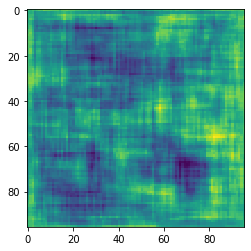

In [38]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

## Test Run Discriminator

In [40]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49966928]], shape=(1, 1), dtype=float32)


## Defining Loss Function

In [42]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Setting Optimizers

In [43]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

## Gradient Descend 

GradientTape to allow the discriminator and generator to be independently trained together.

In [44]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

## Setting Up Training Methodology

In [46]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

## Training

In [48]:
#train(train_dataset, EPOCHS)
train(train_dataset, 2)

Epoch 1, gen loss=0.38049280643463135,disc loss=1.5299848318099976, 0:40:32.00
Epoch 2, gen loss=0.31326231360435486,disc loss=1.6265311241149902, 0:38:50.85
Training time: 1:19:25.48


## Saving Results

In [49]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))